In [24]:
import torch
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image as IPImage, display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision.utils import make_grid

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("outputs", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)
print(f"Using device: {DEVICE}")

Using device: cuda


In [25]:
#Hyperparameters
NUM_FRAMES    = 8
IMG_SIZE      = 64
NUM_TIMESTEPS = 500
NUM_EPOCHS    = 50
BATCH_SIZE    = 4
LR            = 1e-4
MODEL_CHANNELS= 64
NUM_VIDEOS    = 600

print(f"Config: {NUM_FRAMES} frames | {IMG_SIZE}px | {NUM_TIMESTEPS} steps | "
      f"{NUM_EPOCHS} epochs | batch {BATCH_SIZE}")

Config: 8 frames | 64px | 500 steps | 50 epochs | batch 4


In [26]:
#  Sinusoidal Time Embedding
class SinusoidalPosEmb(nn.Module):
    """
    Encodes timestep t into a vector so the model knows
    how much noise has been added at each denoising step.
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(
            -math.log(10000) * torch.arange(half, device=device) / (half - 1)
        )
        args = t[:, None].float() * freqs[None]
        return torch.cat([args.sin(), args.cos()], dim=-1)

In [27]:
#  Residual Block with Time Conditioning
class ResBlock(nn.Module):
    """
    2D residual block. Time embedding is injected as scale+shift
    (called FiLM or AdaGN conditioning) so the model adapts
    its behavior per noise level.
    """
    def __init__(self, in_ch, out_ch, time_emb_dim, groups=8):
        super().__init__()
        groups = min(groups, in_ch, out_ch)  # safety for small channels
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_ch * 2)
        )
        self.block1 = nn.Sequential(
            nn.GroupNorm(groups, in_ch), nn.SiLU(),
            nn.Conv2d(in_ch, out_ch, 3, padding=1)
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(groups, out_ch), nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1)
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        scale_shift = self.time_mlp(t_emb)[:, :, None, None]
        scale, shift = scale_shift.chunk(2, dim=1)
        h = h * (scale + 1) + shift
        h = self.block2(h)
        return h + self.res_conv(x)

In [28]:
#  Spatial Self-Attention (within each frame)
class SpatialAttention(nn.Module):
    """
    Multi-head self-attention across spatial positions
    within a single frame. Captures long-range spatial deps.
    """
    def __init__(self, dim, heads=4):
        super().__init__()
        self.heads = heads
        self.norm  = nn.GroupNorm(1, dim)
        self.qkv   = nn.Conv2d(dim, dim * 3, 1)
        self.proj  = nn.Conv2d(dim, dim, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h).reshape(B, 3, self.heads, C // self.heads, H * W)
        q, k, v = qkv.unbind(1)
        scale = (C // self.heads) ** -0.5
        attn  = torch.einsum('bhdi,bhdj->bhij', q, k) * scale
        attn  = attn.softmax(dim=-1)
        out   = torch.einsum('bhij,bhdj->bhdi', attn, v).reshape(B, C, H, W)
        return self.proj(out) + x

In [29]:
#  Temporal Attention (across frames)
class TemporalAttention(nn.Module):
    """
     Core contribution of Video Diffusion Models

    Applies self-attention ACROSS the time axis for each
    spatial location. This lets the model learn temporal
    coherence (consistent motion) between frames.

    Factorized design (paper Section 3):
      - Spatial conv  → handles per-frame appearance
      - Temporal attn → handles motion/consistency
    """
    def __init__(self, dim, heads=4):
        super().__init__()
        self.heads = heads
        self.norm  = nn.LayerNorm(dim)
        self.qkv   = nn.Linear(dim, dim * 3)
        self.proj  = nn.Linear(dim, dim)

    def forward(self, x):
        B, T, C, H, W = x.shape
        # Reshape: treat each spatial position as an independent sequence of T tokens
        x_flat = x.permute(0, 3, 4, 1, 2).reshape(B * H * W, T, C)
        h = self.norm(x_flat)
        qkv = self.qkv(h).reshape(B * H * W, T, 3, self.heads, C // self.heads)
        q, k, v = qkv.unbind(2)
        q = q.transpose(1, 2); k = k.transpose(1, 2); v = v.transpose(1, 2)
        attn = (q @ k.transpose(-2, -1)) * ((C // self.heads) ** -0.5)
        attn = attn.softmax(dim=-1)
        out  = (attn @ v).transpose(1, 2).reshape(B * H * W, T, C)
        out  = self.proj(out) + x_flat
        return out.reshape(B, H, W, T, C).permute(0, 3, 4, 1, 2)

In [30]:
#  3D U-Net (Space-Time Factored)
class VideoUNet(nn.Module):
    """
    Space-Time U-Net for Video Diffusion

    Architecture:
      Input (B,T,C,H,W) → flatten frames to batch →
      Encoder (ResBlock + downsampling) → Bottleneck → Decoder (ResBlock + upsampling) →
      Output (B,T,C,H,W)

    Temporal attention is inserted after spatial ops at each level.
    """
    def __init__(self, in_ch=3, model_ch=32, out_ch=3, num_frames=8,
                 ch_mults=(1,2,4), attn_res=(1,2), n_res=1, t_emb_dim=128):
        super().__init__()
        self.num_frames = num_frames
        channels = [model_ch * m for m in ch_mults]

        # Time embedding MLP
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(model_ch),
            nn.Linear(model_ch, t_emb_dim),
            nn.SiLU(),
            nn.Linear(t_emb_dim, t_emb_dim),
        )

        self.init_conv = nn.Conv2d(in_ch, model_ch, 3, padding=1)

        #  Encoder
        self.enc_blocks = nn.ModuleList()
        self.enc_sattn  = nn.ModuleList()
        self.enc_tattn  = nn.ModuleList()
        self.enc_down   = nn.ModuleList()
        in_c = model_ch
        for i, out_c in enumerate(channels):
            blks = nn.ModuleList([ResBlock(in_c if j==0 else out_c, out_c, t_emb_dim)
                                  for j in range(n_res)])
            self.enc_blocks.append(blks)
            self.enc_sattn.append(SpatialAttention(out_c)  if i in attn_res else nn.Identity())
            self.enc_tattn.append(TemporalAttention(out_c) if i in attn_res else nn.Identity())
            self.enc_down.append(nn.Conv2d(out_c, out_c, 3, stride=2, padding=1)
                                 if i < len(channels)-1 else nn.Identity())
            in_c = out_c

        #  Bottleneck
        self.mid1     = ResBlock(in_c, in_c, t_emb_dim)
        self.mid_sattn= SpatialAttention(in_c)
        self.mid_tattn= TemporalAttention(in_c)
        self.mid2     = ResBlock(in_c, in_c, t_emb_dim)

        #  Decoder
        self.dec_blocks = nn.ModuleList()
        self.dec_sattn  = nn.ModuleList()
        self.dec_tattn  = nn.ModuleList()
        self.dec_up     = nn.ModuleList()
        for i, out_c in enumerate(reversed(channels)):
            skip_c = channels[-(i+1)]
            blks = nn.ModuleList()
            for j in range(n_res):
                _in = in_c + skip_c if j == 0 else out_c
                blks.append(ResBlock(_in, out_c, t_emb_dim))
            self.dec_blocks.append(blks)
            dec_idx = len(channels)-1-i
            self.dec_sattn.append(SpatialAttention(out_c)  if dec_idx in attn_res else nn.Identity())
            self.dec_tattn.append(TemporalAttention(out_c) if dec_idx in attn_res else nn.Identity())
            self.dec_up.append(nn.ConvTranspose2d(out_c, out_c, 4, stride=2, padding=1)
                               if i < len(channels)-1 else nn.Identity())
            in_c = out_c

        self.out_norm = nn.GroupNorm(min(8, model_ch), model_ch)
        self.out_conv = nn.Conv2d(model_ch, out_ch, 1)

    def _sattn(self, layer, x):
        return x if isinstance(layer, nn.Identity) else layer(x)

    def _tattn(self, layer, x, B, T):
        if isinstance(layer, nn.Identity): return x
        BT, C, H, W = x.shape
        return layer(x.reshape(B,T,C,H,W)).reshape(BT,C,H,W)

    def forward(self, x, t):
        B, T, C, H, W = x.shape
        t_emb = self.time_emb(t)                        # (B, t_emb_dim)
        t_exp = t_emb.repeat_interleave(T, dim=0)       # (B*T, t_emb_dim)
        x = x.reshape(B*T, C, H, W)
        h = self.init_conv(x)

        skips = []
        for blks, sa, ta, down in zip(self.enc_blocks, self.enc_sattn,
                                       self.enc_tattn,  self.enc_down):
            for blk in blks: h = blk(h, t_exp)
            h = self._sattn(sa, h)
            h = self._tattn(ta, h, B, T)
            skips.append(h)
            h = down(h)

        h = self.mid1(h, t_exp)
        h = self._sattn(self.mid_sattn, h)
        h = self._tattn(self.mid_tattn, h, B, T)
        h = self.mid2(h, t_exp)

        for i, (blks, sa, ta, up) in enumerate(zip(self.dec_blocks, self.dec_sattn,
                                                     self.dec_tattn,  self.dec_up)):
            h = torch.cat([h, skips[-(i+1)]], dim=1)
            for blk in blks: h = blk(h, t_exp)
            h = self._sattn(sa, h)
            h = self._tattn(ta, h, B, T)
            h = up(h)

        h = F.silu(self.out_norm(h))
        return self.out_conv(h).reshape(B, T, C, H, W)

print(" Model architecture defined")

 Model architecture defined


In [31]:
# Gaussian Diffusion Process
class GaussianDiffusion:
    """
    DDPM diffusion process extended to videos.

     Forward process (training)
      q(x_t|x_0) = N(x_t; √ᾱ_t·x_0, (1-ᾱ_t)·I)
      One-step corruption: add noise directly at any t.

     Reverse process (sampling)
      p_θ(x_{t-1}|x_t): model predicts noise ε_θ,
      we recover x_{t-1} iteratively.

     Loss
      L = E[‖ε − ε_θ(x_t, t)‖²]
      Simple MSE on the predicted noise (Ho et al. 2020).
    """
    def __init__(self, T=1000, beta_start=1e-4, beta_end=0.02):
        self.T = T
        betas  = torch.linspace(beta_start, beta_end, T)
        alphas = 1.0 - betas
        abar   = torch.cumprod(alphas, dim=0)
        abar_prev = F.pad(abar[:-1], (1,0), value=1.0)

        self.betas         = betas
        self.abar          = abar
        self.sqrt_abar     = abar.sqrt()
        self.sqrt_1m_abar  = (1 - abar).sqrt()
        self.post_var      = betas * (1 - abar_prev) / (1 - abar)
        self.sqrt_recip_a  = (1.0 / alphas).sqrt()

    def _get(self, arr, t, shape):
        v = arr.to(t.device)[t]
        return v.reshape(t.shape[0], *((1,)*(len(shape)-1)))

    def q_sample(self, x0, t, noise=None):
        """Add noise to clean video at timestep t (forward process)."""
        if noise is None: noise = torch.randn_like(x0)
        return (self._get(self.sqrt_abar, t, x0.shape) * x0 +
                self._get(self.sqrt_1m_abar, t, x0.shape) * noise)

    def loss(self, model, x0, t):
        """
        Compute training loss:
          1. Sample noise ε ~ N(0,I)
          2. Corrupt: x_t = √ᾱ_t·x_0 + √(1-ᾱ_t)·ε
          3. Predict: ε_θ = model(x_t, t)
          4. Loss = MSE(ε, ε_θ)
        """
        noise = torch.randn_like(x0)
        xt    = self.q_sample(x0, t, noise)
        pred  = model(xt, t)
        return F.mse_loss(pred, noise)

    @torch.no_grad()
    def p_sample(self, model, xt, t_val):
        """
        One reverse step: sample x_{t-1} from p_θ(x_{t-1}|x_t).
        Uses the DDPM ancestral sampler formula.
        """
        B = xt.shape[0]
        t = torch.full((B,), t_val, device=xt.device, dtype=torch.long)
        eps    = model(xt, t)
        beta_t = self._get(self.betas, t, xt.shape)
        s1m    = self._get(self.sqrt_1m_abar, t, xt.shape)
        sr     = self._get(self.sqrt_recip_a, t, xt.shape)
        mean   = sr * (xt - beta_t / s1m * eps)
        if t_val == 0:
            return mean
        noise = torch.randn_like(xt)
        var   = self._get(self.post_var, t, xt.shape)
        return mean + var.sqrt() * noise

    @torch.no_grad()
    def sample(self, model, shape, device, verbose=True):
        """
        Full generation: start from x_T ~ N(0,I) and
        iteratively denoise T times to get a clean video x_0.
        """
        x = torch.randn(shape, device=device)
        for t in reversed(range(self.T)):
            if verbose and t % 50 == 0:
                print(f"  Denoising step {self.T-t}/{self.T} (t={t})")
            x = self.p_sample(model, x, t)
        return x

print(" Gaussian diffusion defined")

 Gaussian diffusion defined


 Dataset ready: 600 videos | 150 batches/epoch


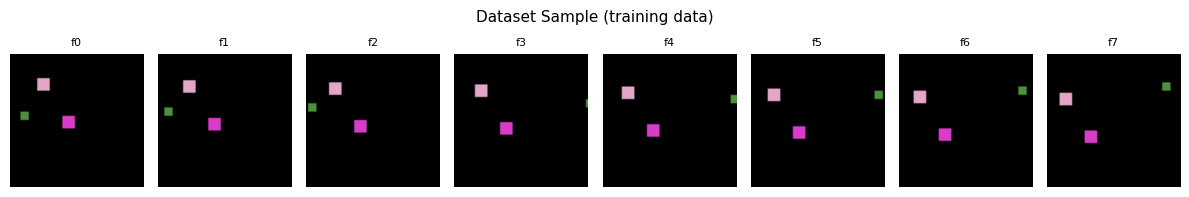

Dataset sample saved


In [32]:
# Synthetic Dataset
class SyntheticVideoDataset(Dataset):
    """
    Generates short synthetic videos with moving colored rectangles.
    Used as a lightweight stand-in for real video datasets.

    To use real data instead, replace __getitem__ with your
    video loading logic (e.g., from UCF-101 or Kinetics-400).
    """
    def __init__(self, n=400, T=8, size=32, n_obj=3):
        self.n = n; self.T = T; self.S = size; self.n_obj = n_obj

    def __len__(self): return self.n

    def __getitem__(self, idx):
        video = np.zeros((self.T, 3, self.S, self.S), dtype=np.float32)
        for _ in range(self.n_obj):
            x0  = np.random.randint(0, self.S - 8)
            y0  = np.random.randint(0, self.S - 8)
            vx  = np.random.choice([-2,-1,1,2])
            vy  = np.random.choice([-2,-1,1,2])
            sz  = np.random.randint(4, 10)
            col = np.random.rand(3).astype(np.float32)
            for t in range(self.T):
                x = (x0 + vx*t) % self.S
                y = (y0 + vy*t) % self.S
                video[t, :, y:min(y+sz,self.S), x:min(x+sz,self.S)] = col[:,None,None]
        return torch.tensor(video * 2.0 - 1.0)   # normalize to [-1, 1]

dataset = SyntheticVideoDataset(n=NUM_VIDEOS, T=NUM_FRAMES, size=IMG_SIZE)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(f" Dataset ready: {len(dataset)} videos | {len(loader)} batches/epoch")

# Quick sanity check — display one sample
sample = (dataset[0] + 1) / 2.0  # → [0,1]
fig, axes = plt.subplots(1, NUM_FRAMES, figsize=(NUM_FRAMES*1.5, 2))
for i, ax in enumerate(axes):
    ax.imshow(sample[i].permute(1,2,0).numpy().clip(0,1))
    ax.set_title(f"f{i}", fontsize=8); ax.axis("off")
fig.suptitle("Dataset Sample (training data)", fontsize=11)
plt.tight_layout()
plt.savefig("outputs/dataset_sample.png", dpi=120, bbox_inches='tight')
plt.show()
print("Dataset sample saved")

In [33]:
#Build Model
model = VideoUNet(
    in_ch=3,
    model_ch=MODEL_CHANNELS,
    out_ch=3,
    num_frames=NUM_FRAMES,
    ch_mults=(1, 2, 4),
    attn_res=(1, 2),
    n_res=1,
    t_emb_dim=128,
).to(DEVICE)

diffusion = GaussianDiffusion(T=NUM_TIMESTEPS, beta_start=1e-4, beta_end=0.02)

total_params = sum(p.numel() for p in model.parameters())
print(f"  Model ready on {DEVICE}")
print(f"  Parameters : {total_params:,}")
print(f"  Approx size: {total_params * 4 / 1e6:.1f} MB (float32)")


  Model ready on cuda
  Parameters : 10,022,467
  Approx size: 40.1 MB (float32)


In [35]:
# Training Loop
optimizer  = torch.optim.Adam(model.parameters(), lr=LR)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
scaler     = GradScaler()   # mixed precision for speed on T4

loss_history = []
best_loss    = float("inf")

print(f"\nStarting training: {NUM_EPOCHS} epochs × {len(loader)} steps")

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0

    for step, batch in enumerate(loader):
        batch = batch.to(DEVICE)              # (B, T, 3, H, W)
        B     = batch.shape[0]

        # Sample random timestep for each video in the batch
        t = torch.randint(0, diffusion.T, (B,), device=DEVICE)

        optimizer.zero_grad()

        # Mixed precision forward pass (faster on T4/A100)
        with autocast():
            loss = diffusion.loss(model, batch, t)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # stability
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    loss_history.append(avg_loss)
    scheduler.step()

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pt")

    print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}]  Loss: {avg_loss:.5f}"
          + (" ← best" if avg_loss == best_loss else ""))

print("\n Training complete!")
print(f"  Best loss : {best_loss:.5f}")
print(f"  Saved to  : checkpoints/best_model.pt")


Starting training: 50 epochs × 150 steps


/tmp/ipython-input-2048997227.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = GradScaler()   # mixed precision for speed on T4
/tmp/ipython-input-2048997227.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [  1/50]  Loss: 0.20704 ← best
Epoch [  2/50]  Loss: 0.05389 ← best
Epoch [  3/50]  Loss: 0.04068 ← best
Epoch [  4/50]  Loss: 0.02414 ← best
Epoch [  5/50]  Loss: 0.02560
Epoch [  6/50]  Loss: 0.01838 ← best
Epoch [  7/50]  Loss: 0.01833 ← best
Epoch [  8/50]  Loss: 0.01859
Epoch [  9/50]  Loss: 0.01797 ← best
Epoch [ 10/50]  Loss: 0.01356 ← best
Epoch [ 11/50]  Loss: 0.01407
Epoch [ 12/50]  Loss: 0.01564
Epoch [ 13/50]  Loss: 0.01260 ← best
Epoch [ 14/50]  Loss: 0.01188 ← best
Epoch [ 15/50]  Loss: 0.01065 ← best
Epoch [ 16/50]  Loss: 0.00940 ← best
Epoch [ 17/50]  Loss: 0.00888 ← best
Epoch [ 18/50]  Loss: 0.01143
Epoch [ 19/50]  Loss: 0.00925
Epoch [ 20/50]  Loss: 0.00908
Epoch [ 21/50]  Loss: 0.00788 ← best
Epoch [ 22/50]  Loss: 0.00670 ← best
Epoch [ 23/50]  Loss: 0.00771
Epoch [ 24/50]  Loss: 0.00645 ← best
Epoch [ 25/50]  Loss: 0.00684
Epoch [ 26/50]  Loss: 0.00684
Epoch [ 27/50]  Loss: 0.00690
Epoch [ 28/50]  Loss: 0.00610 ← best
Epoch [ 29/50]  Loss: 0.00551 ← best
Epoc

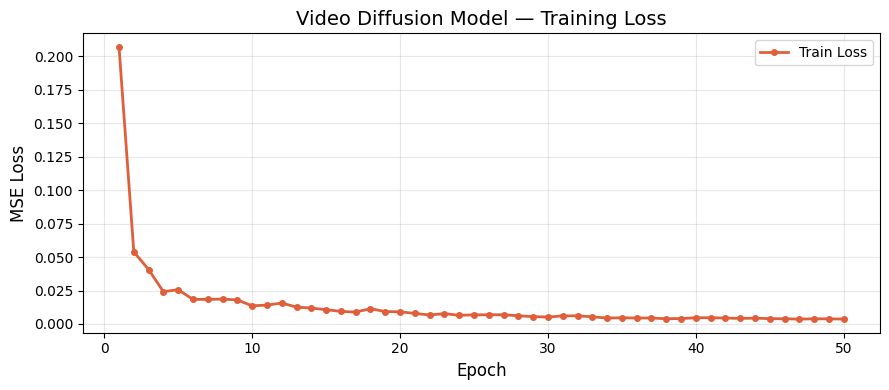

 Loss curve saved → outputs/training_loss.png


In [36]:
# Plot Training Loss
plt.figure(figsize=(9, 4))
plt.plot(range(1, NUM_EPOCHS+1), loss_history, marker='o',
         linewidth=2, markersize=4, color='#E05E3A', label="Train Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.title("Video Diffusion Model — Training Loss", fontsize=14)
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig("outputs/training_loss.png", dpi=120)
plt.show()
print(" Loss curve saved → outputs/training_loss.png")

In [37]:
#  Generate Videos (Inference)

# Load best checkpoint before generating
model.load_state_dict(torch.load("checkpoints/best_model.pt", map_location=DEVICE))
model.eval()

NUM_GEN = 4   # number of videos to generate

print(f"Generating {NUM_GEN} videos ({NUM_FRAMES} frames each)...")
print(f"Running {NUM_TIMESTEPS} denoising steps...\n")

with torch.no_grad():
    generated = diffusion.sample(
        model,
        shape=(NUM_GEN, NUM_FRAMES, 3, IMG_SIZE, IMG_SIZE),
        device=DEVICE,
        verbose=True
    )

# Denormalize from [-1,1] → [0,1]
generated = (generated.clamp(-1, 1) + 1) / 2.0
generated = generated.cpu()
print(f"\n Generated tensor shape: {generated.shape}")

Generating 4 videos (8 frames each)...
Running 500 denoising steps...

  Denoising step 50/500 (t=450)
  Denoising step 100/500 (t=400)
  Denoising step 150/500 (t=350)
  Denoising step 200/500 (t=300)
  Denoising step 250/500 (t=250)
  Denoising step 300/500 (t=200)
  Denoising step 350/500 (t=150)
  Denoising step 400/500 (t=100)
  Denoising step 450/500 (t=50)
  Denoising step 500/500 (t=0)

 Generated tensor shape: torch.Size([4, 8, 3, 64, 64])


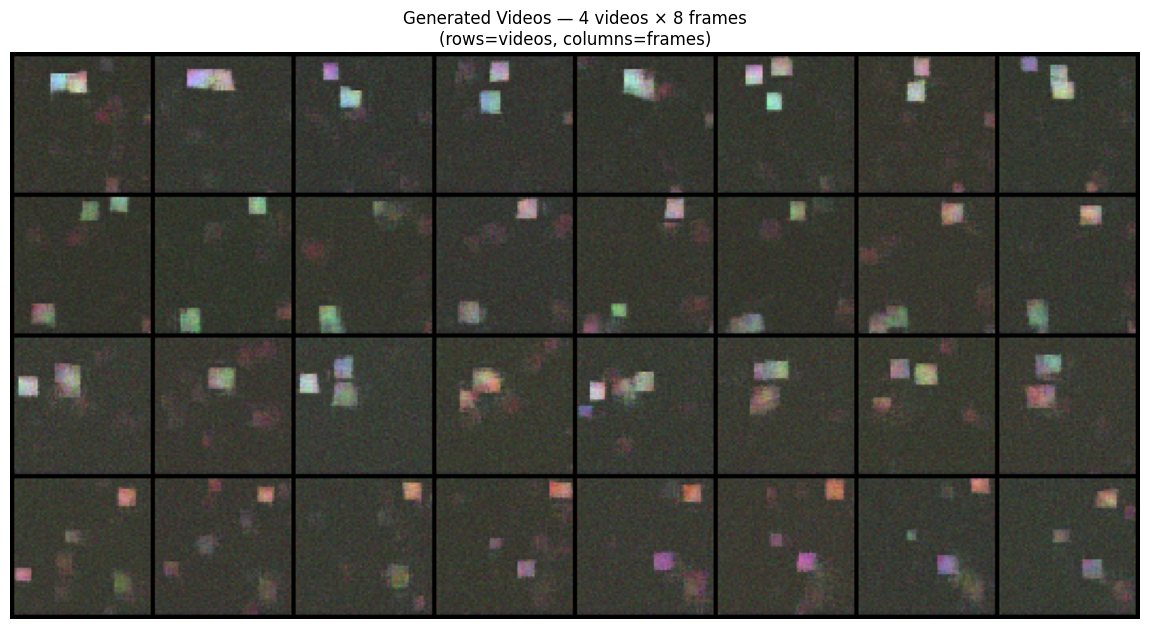

 Generated frames saved → outputs/generated_frames.png


In [38]:
# Visualize Generated Frames

B, T, C, H, W = generated.shape
frames = generated.reshape(B*T, C, H, W)
grid   = make_grid(frames, nrow=T, padding=2).permute(1,2,0).numpy().clip(0,1)

fig, ax = plt.subplots(figsize=(T*1.6, B*1.6))
ax.imshow(grid)
ax.axis("off")
ax.set_title(f"Generated Videos — {B} videos × {T} frames\n"
             f"(rows=videos, columns=frames)", fontsize=12)
plt.tight_layout()
plt.savefig("outputs/generated_frames.png", dpi=150, bbox_inches='tight')
plt.show()
print(" Generated frames saved → outputs/generated_frames.png")

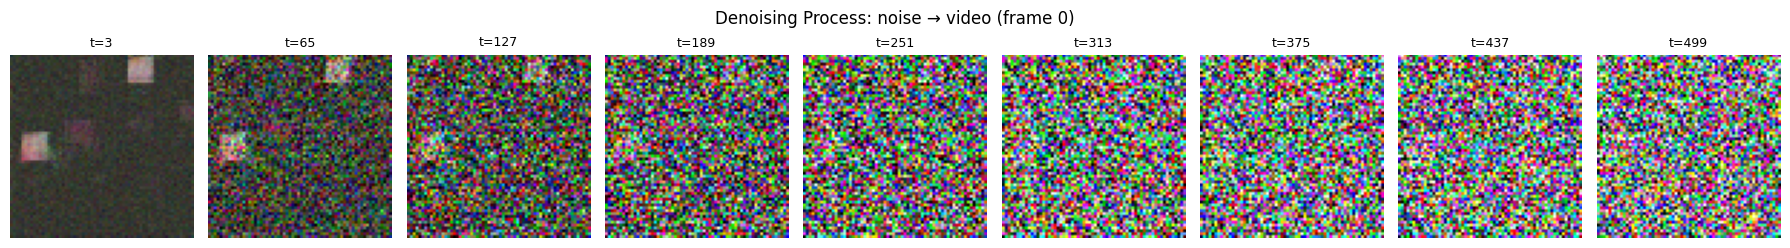

 Denoising visualization saved → outputs/denoising_process.png


In [39]:
#  Visualize Denoising Process

"""
Shows how the model progressively removes noise from x_T → x_0.
We capture intermediate states every N steps.
"""

model.eval()
n_snapshots = 8
snapshot_interval = NUM_TIMESTEPS // n_snapshots
snapshot_times = list(range(NUM_TIMESTEPS-1, -1, -snapshot_interval))

x_denoise = torch.randn((1, NUM_FRAMES, 3, IMG_SIZE, IMG_SIZE), device=DEVICE)
snapshots  = []

with torch.no_grad():
    for t_val in reversed(range(NUM_TIMESTEPS)):
        x_denoise = diffusion.p_sample(model, x_denoise, t_val)
        if t_val in snapshot_times:
            # Capture first frame of the first video
            frame = ((x_denoise[0, 0].cpu().clamp(-1,1) + 1) / 2.0)
            snapshots.append((frame.permute(1,2,0).numpy(), t_val))

# Reverse to show t=T → t=0
snapshots = list(reversed(snapshots))

fig, axes = plt.subplots(1, len(snapshots), figsize=(len(snapshots)*2, 2.5))
for ax, (img, t_val) in zip(axes, snapshots):
    ax.imshow(img.clip(0,1))
    ax.set_title(f"t={t_val}", fontsize=9)
    ax.axis("off")
fig.suptitle("Denoising Process: noise → video (frame 0)", fontsize=12)
plt.tight_layout()
plt.savefig("outputs/denoising_process.png", dpi=120, bbox_inches='tight')
plt.show()
print(" Denoising visualization saved → outputs/denoising_process.png")

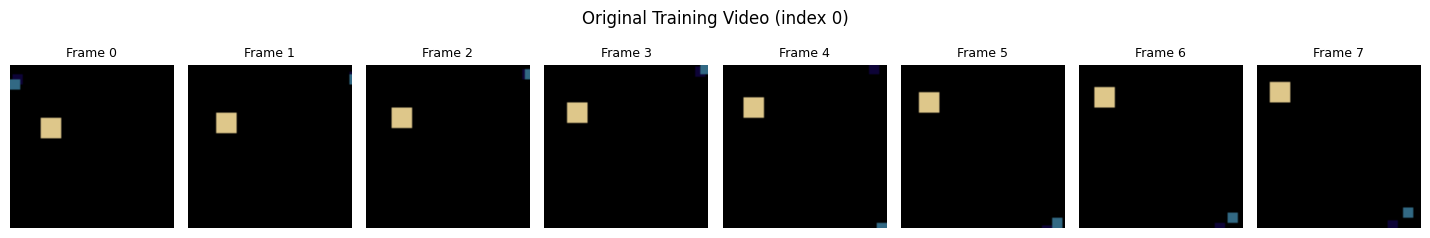

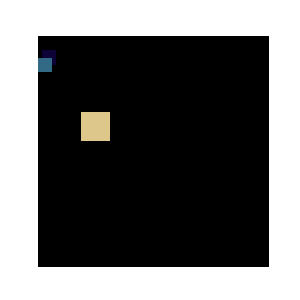

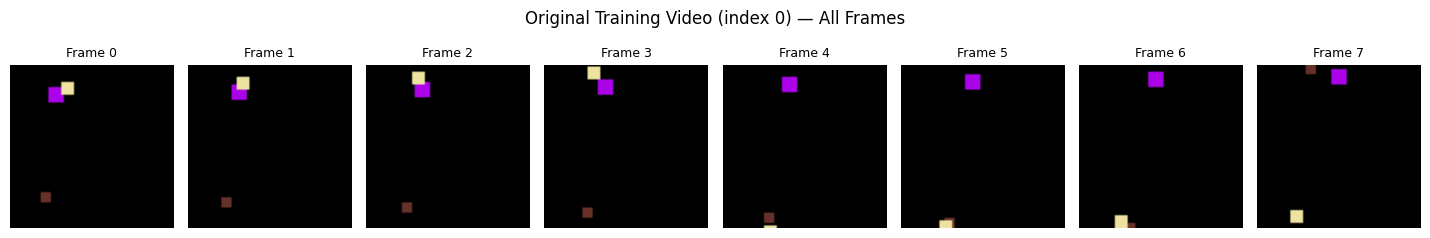

✓ Saved → outputs/original_video_frames.png

Displaying original video as animation:


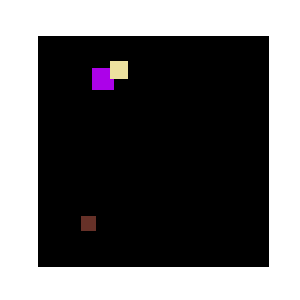


Original (top) vs Generated (bottom) — Frame Comparison:


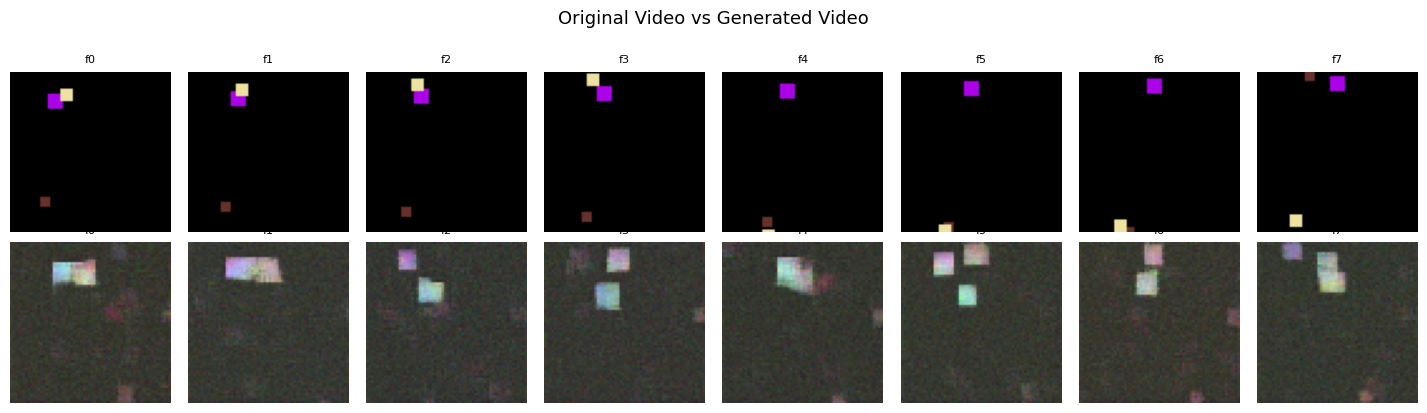

Saved → outputs/original_vs_generated.png


In [40]:
# Display Original Dataset Video


"""
Shows a real video from the training dataset as:
  1. A frame-by-frame grid (all frames side by side)
  2. An animated GIF playing the video in Colab
"""

import matplotlib.animation as animation
from IPython.display import Image as IPImage, display

def save_gif(video_tensor, path, fps=5):
    frames_np = video_tensor.permute(0,2,3,1).numpy()
    frames_np = (frames_np.clip(0,1) * 255).astype(np.uint8)
    fig, ax = plt.subplots(figsize=(3,3))
    ax.axis("off")
    im = ax.imshow(frames_np[0], animated=True)
    def update(i):
        im.set_array(frames_np[i])
        return [im]
    ani = animation.FuncAnimation(fig, update, frames=len(frames_np),
                                  interval=1000//fps, blit=True)
    ani.save(path, writer='pillow', fps=fps)
    plt.close()

# ── Now display the original video ──

VIDEO_IDX = 0
original = dataset[VIDEO_IDX]
original_01 = (original + 1) / 2.0

# Frame grid
fig, axes = plt.subplots(1, NUM_FRAMES, figsize=(NUM_FRAMES * 1.8, 2.5))
for i, ax in enumerate(axes):
    ax.imshow(original_01[i].permute(1,2,0).numpy().clip(0,1))
    ax.set_title(f"Frame {i}", fontsize=9)
    ax.axis("off")
fig.suptitle(f"Original Training Video (index {VIDEO_IDX})", fontsize=12)
plt.tight_layout()
plt.savefig("outputs/original_video_frames.png", dpi=150, bbox_inches='tight')
plt.show()

# Animated GIF
save_gif(original_01, "outputs/original_video.gif", fps=4)
display(IPImage(filename="outputs/original_video.gif"))
#  Pick any video index from the dataset
VIDEO_IDX = 0   # change this (0 to NUM_VIDEOS-1) to see different videos

original = dataset[VIDEO_IDX]          # (T, 3, H, W)  in [-1, 1]
original_01 = (original + 1) / 2.0    # → [0, 1] for display

#  Frame Grid
fig, axes = plt.subplots(1, NUM_FRAMES, figsize=(NUM_FRAMES * 1.8, 2.5))
for i, ax in enumerate(axes):
    ax.imshow(original_01[i].permute(1, 2, 0).numpy().clip(0, 1))
    ax.set_title(f"Frame {i}", fontsize=9)
    ax.axis("off")
fig.suptitle(f"Original Training Video (index {VIDEO_IDX}) — All Frames", fontsize=12)
plt.tight_layout()
plt.savefig("outputs/original_video_frames.png", dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved → outputs/original_video_frames.png")

# Animated GIF
save_gif(original_01, "outputs/original_video.gif", fps=4)

print("\nDisplaying original video as animation:")
display(IPImage(filename="outputs/original_video.gif"))

#  3. Side-by-side: Original vs Generated
print("\nOriginal (top) vs Generated (bottom) — Frame Comparison:")

fig, axes = plt.subplots(2, NUM_FRAMES, figsize=(NUM_FRAMES * 1.8, 4))

for i in range(NUM_FRAMES):
    # Original
    axes[0, i].imshow(original_01[i].permute(1,2,0).numpy().clip(0,1))
    axes[0, i].set_title(f"f{i}", fontsize=8)
    axes[0, i].axis("off")
    # Generated (video 0)
    axes[1, i].imshow(generated[0, i].permute(1,2,0).numpy().clip(0,1))
    axes[1, i].set_title(f"f{i}", fontsize=8)
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("Original", fontsize=10, rotation=90, labelpad=40)
axes[1, 0].set_ylabel("Generated", fontsize=10, rotation=90, labelpad=40)
fig.suptitle("Original Video vs Generated Video", fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig("outputs/original_vs_generated.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved → outputs/original_vs_generated.png")

✓ Saved → outputs/generated_video_1.gif
✓ Saved → outputs/generated_video_2.gif
✓ Saved → outputs/generated_video_3.gif
✓ Saved → outputs/generated_video_4.gif

Displaying generated video 1:


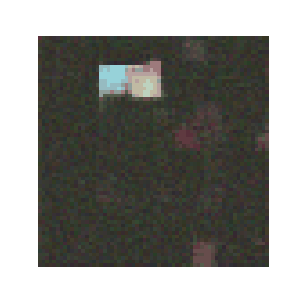

In [41]:
#Save as Animated GIF & Display
#display generated video

def save_gif(video_tensor, path, fps=5):
    """
    Save a single generated video (T, C, H, W) as an animated GIF.
    video_tensor values should be in [0, 1].
    """
    frames_np = video_tensor.permute(0,2,3,1).numpy()
    frames_np = (frames_np.clip(0,1) * 255).astype(np.uint8)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axis("off")
    im = ax.imshow(frames_np[0], animated=True)

    def update(i):
        im.set_array(frames_np[i])
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(frames_np),
                                  interval=1000//fps, blit=True)
    ani.save(path, writer='pillow', fps=fps)
    plt.close()

# Save all generated videos as GIFs
for i in range(min(NUM_GEN, 4)):
    path = f"outputs/generated_video_{i+1}.gif"
    save_gif(generated[i], path, fps=4)
    print(f"✓ Saved → {path}")

# Display first GIF inline in Colab
print("\nDisplaying generated video 1:")
display(IPImage(filename="outputs/generated_video_1.gif"))

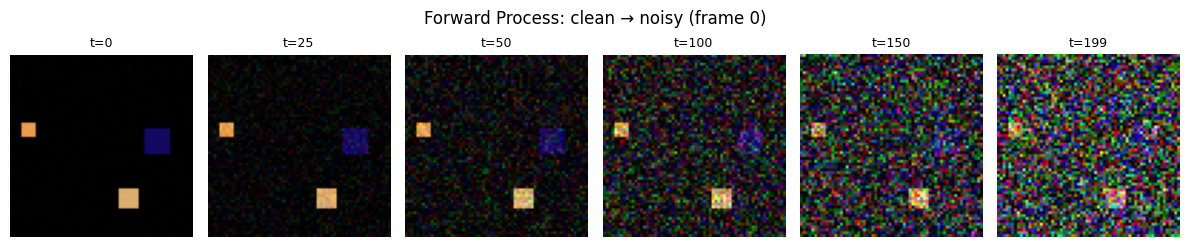

 Forward process saved → outputs/forward_process.png


In [42]:
# Forward Process Visualization

"""
Shows the FORWARD (noising) process: clean video → noisy video.
This is just the q(x_t|x_0) process used during training.
"""

clean_sample = dataset[0].unsqueeze(0).to(DEVICE)   # (1, T, C, H, W)
timesteps_to_show = [0, 25, 50, 100, 150, 199] if NUM_TIMESTEPS >= 200 \
                    else list(range(0, NUM_TIMESTEPS, NUM_TIMESTEPS//6))

fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(len(timesteps_to_show)*2, 2.5))

with torch.no_grad():
    for ax, t_val in zip(axes, timesteps_to_show):
        t_tensor = torch.tensor([t_val], device=DEVICE)
        noisy = diffusion.q_sample(clean_sample, t_tensor)
        # Show frame 0 of video 0
        img = ((noisy[0, 0].cpu().clamp(-1,1) + 1) / 2.0)
        ax.imshow(img.permute(1,2,0).numpy().clip(0,1))
        ax.set_title(f"t={t_val}", fontsize=9)
        ax.axis("off")

fig.suptitle("Forward Process: clean → noisy (frame 0)", fontsize=12)
plt.tight_layout()
plt.savefig("outputs/forward_process.png", dpi=120, bbox_inches='tight')
plt.show()
print(" Forward process saved → outputs/forward_process.png")